In [4]:
import os
import numpy as np
from sklearn import preprocessing, model_selection, metrics
from tensorflow import keras
from matplotlib import pyplot as plt

In [5]:
RANDOM_SEED = 42

In [6]:
def load_and_transform_images():
    # Define the path to your dataset
    data_dir = "./datasets/images/"

    # Get the list of all categories (subfolder names)
    categories = os.listdir(data_dir)

    # Initialize empty lists to store the images and labels
    images = []
    labels = []

    # Loop over each category
    for category in categories:
        # Get the list of all image file names for this category
        image_files = os.listdir(os.path.join(data_dir, category))

        # Loop over each image file
        for image_file in image_files:
            # Load the image and normalize pixel values to [0, 1]
            img = keras.preprocessing.image.load_img(
                os.path.join(data_dir, category, image_file), target_size=(256, 256)
            )
            img = keras.preprocessing.image.img_to_array(img)
            img = img / 255.0

            # Append the image and its label to the respective lists
            images.append(img)
            labels.append(category)

    # Convert the lists into numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    np.save("datasets/images.npy", images)
    np.save("datasets/labels.npy", labels)


if not os.path.exists("datasets/images.npy") or not os.path.exists("datasets/labels.npy"):
    load_and_transform_images()

In [7]:
images = np.load("datasets/images.npy")
labels = np.load("datasets/labels.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/transformed/labels.npy'

In [ ]:
# Number of classes
num_classes = len(np.unique(labels))

In [ ]:
# Initialize the label binarizer
le = preprocessing.LabelEncoder()

# Fit the label binarizer and transform the labels
labels = le.fit_transform(labels)

# Convert the labels to a format that can be used with the model
labels = keras.utils.to_categorical(labels, num_classes)

In [ ]:
# Split the data into training and test sets
X_train_val, X_test, Y_train_val, Y_test = model_selection.train_test_split(
    images, labels, test_size=1 / 8, random_state=RANDOM_SEED
)

# Further split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(
    X_train_val, Y_train_val, test_size=1 / 20, random_state=RANDOM_SEED
)

In [ ]:
def build_model(kernel_sizes: list[tuple[int, int]], conv_filters: list[int], dense_units: int, num_dense: int):
    conv_layers = [
        [
            keras.layers.Conv2D(
                filters=conv_filters[i],
                kernel_size=kernel_size,
                activation="relu",
                input_shape=images.shape[1:],
            )
            if i == 0
            else keras.layers.Conv2D(
                filters=conv_filters[i],
                kernel_size=kernel_size,
                activation="relu",
            ),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Dropout(0.5),
            keras.layers.BatchNormalization() if i != len(kernel_sizes) - 1 else keras.layers.Flatten(),
        ]
        for i, kernel_size in enumerate(kernel_sizes)
    ]

    dense_layers = [
        [keras.layers.Dense(units=dense_units, activation="relu"), keras.layers.Dropout(0.5)] for _ in range(num_dense)
    ]

    layers = (
        [layer for conv_layer in conv_layers for layer in conv_layer]
        + [layer for dense_layer in dense_layers for layer in dense_layer]
        + [keras.layers.Dense(units=num_classes, activation="softmax")]
    )

    model = keras.models.Sequential(layers=layers)

    # model.summary()

    return model

In [ ]:
def train_and_test(model: keras.models.Sequential):
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
        X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=500, callbacks=[early_stopping]
    )

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, Y_test)

    return history, loss, accuracy

In [ ]:
def plot_history(history: keras.callbacks.History):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("accuracy")
    plt.plot(history.epoch, history.history["loss"], label="loss")
    plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
    plt.legend(["loss", "val_loss"])

    plt.subplot(1, 2, 2)
    plt.title("loss")
    plt.plot(history.epoch, history.history["accuracy"], label="accuracy")
    plt.plot(history.epoch, history.history["val_accuracy"], label="val_accuracy")
    plt.legend(["accuracy", "val_accuracy"])

Loss:  3.0223963260650635
Accuracy:  0.10823909193277359


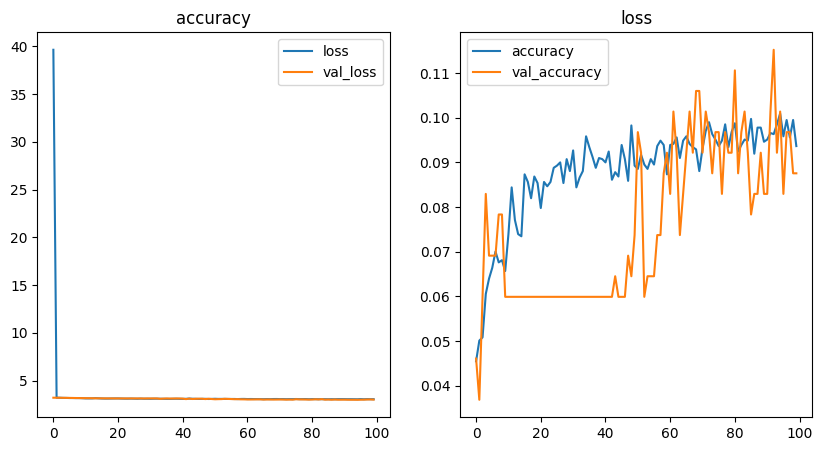

In [ ]:
model = build_model(kernel_sizes=[(11, 11), (5, 5), (3, 3)], conv_filters=[3, 16, 96], dense_units=2048, num_dense=2)
history, loss, accuracy = train_and_test(model)
plot_history(history)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
# # Get the predicted labels
# Y_pred = model.predict(X_test)

# # Convert the predicted labels from probabilities to class labels
# Y_pred_classes = np.argmax(Y_pred, axis=1)

# # Convert the true labels from one-hot encoded vectors to class labels
# Y_true = np.argmax(Y_test, axis=1)

# # Print the classification report
# print(metrics.classification_report(Y_true, Y_pred_classes))

20/20 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        25
           2       0.08      1.00      0.15        52
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00        27
           5       0.00      0.00      0.00        35
           6       0.00      0.00      0.00        45
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        23
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00        32
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00        16
          16       0.00     

c:\Users\Computer\miniconda3\envs\ML-projekat\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Computer\miniconda3\envs\ML-projekat\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Computer\miniconda3\envs\ML-projekat\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r